In [1]:
import numpy as np
import mpmath as mp

from optics.beam import GaussianBeam
from optics.geometrical import ThinLens, Propagation
from optics.diffraction import NaiveDiffraction, UreyDiffraction, LiDiffraction

from matplotlib import pyplot as plt

plt.style.use('bodo')

colors = plt.get_cmap('tab20c').colors

In [6]:
# aperture radius
a = 20e-3

# focal length
f = 25e-3

# wavelength
λ = 532e-9

# focal shift
z = 1e-9

def gaussian(waist):
    return GaussianBeam(waist=waist, wavelength=λ)

def intensity_naive(waist, r):
    I = np.vectorize(NaiveDiffraction(radius=a, focal_length=f, gaussian=gaussian(waist)))(r)
    
    return I / np.max(I)

def intensity_urey(waist, r):
    I = np.vectorize(UreyDiffraction(radius=a, focal_length=f, gaussian=gaussian(waist)))(r)

    return I / np.max(I)

def intensity_li(waist, r):
    I = np.vectorize(LiDiffraction(radius=a, focal_length=f, gaussian=gaussian(waist)))(r)

    return I / np.max(I)

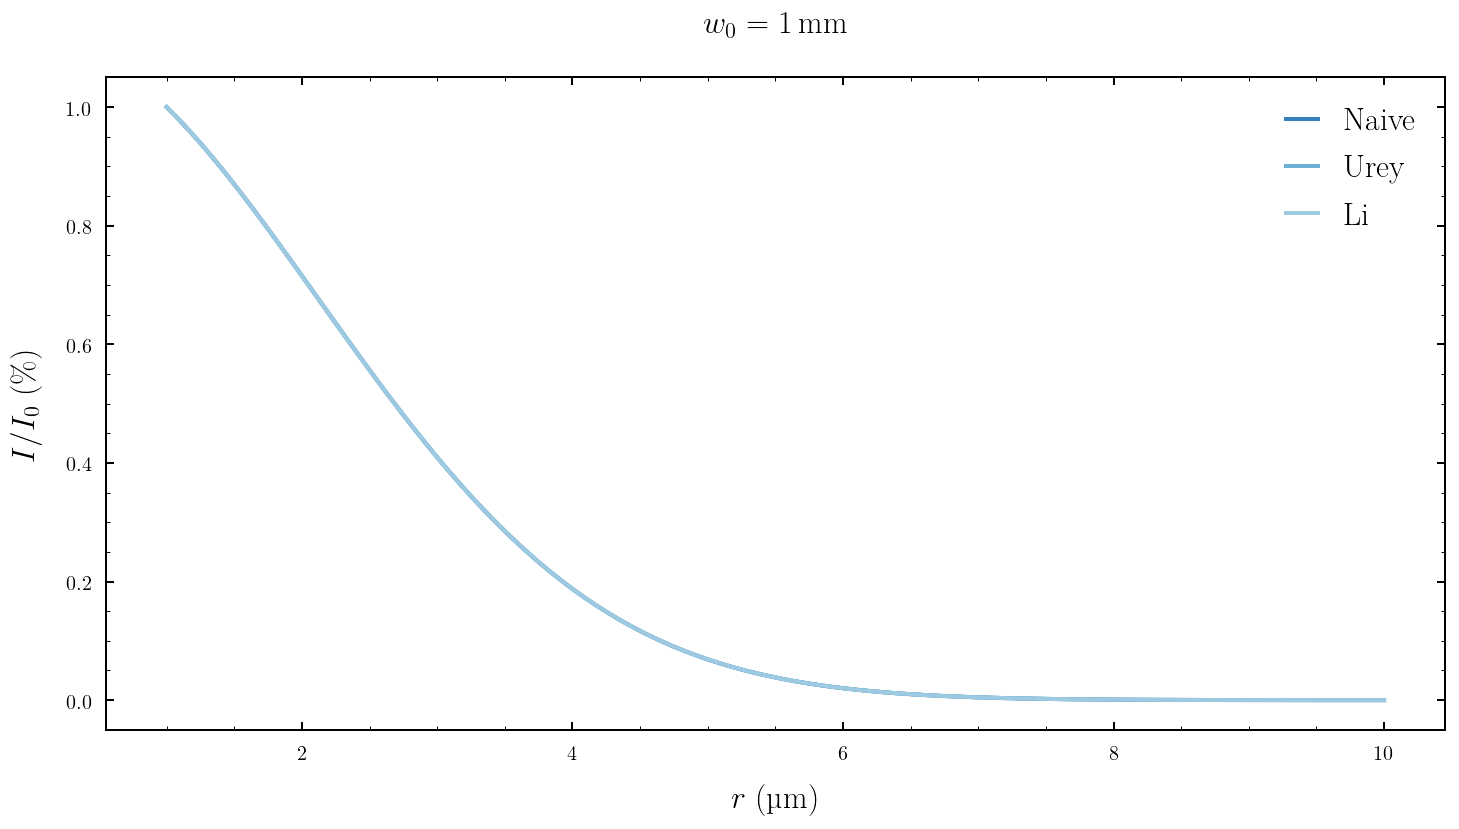

In [10]:
r = np.linspace(1e-6, 10e-6, 100)
w = 1e-3

plt.figure(figsize=(12, 6))
plt.title(r'$w_0=\SI{1}{\milli\meter}$')
plt.plot(r / 1e-6, intensity_naive(w, r), label='Naive', color=colors[0])
plt.plot(r / 1e-6, intensity_urey(w, r), label='Urey', color=colors[1])
plt.plot(r / 1e-6, intensity_li(w, r), label='Li', color=colors[2])
plt.xlabel(r'$r$ (\si{\micro\meter})')
plt.ylabel(r'$I/I_0$ (\si{\percent})')
plt.legend()
plt.show()

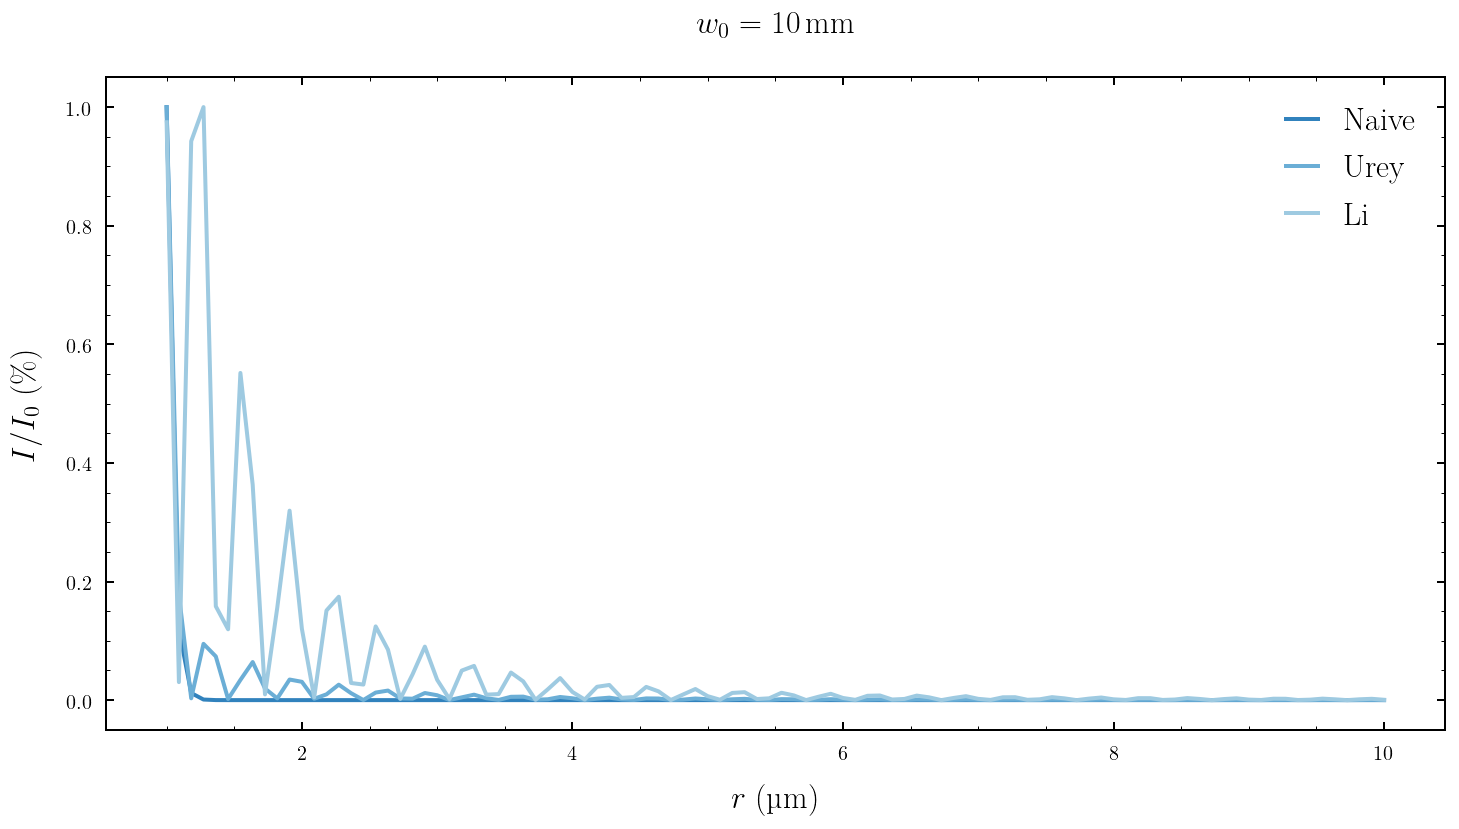

In [11]:
r = np.linspace(1e-6, 10e-6, 100)
w = 10e-3

plt.figure(figsize=(12, 6))
plt.title(r'$w_0=\SI{10}{\milli\meter}$')
plt.plot(r / 1e-6, intensity_naive(w, r), label='Naive', color=colors[0])
plt.plot(r / 1e-6, intensity_urey(w, r), label='Urey', color=colors[1])
plt.plot(r / 1e-6, intensity_li(w, r), label='Li', color=colors[2])
plt.xlabel(r'$r$ (\si{\micro\meter})')
plt.ylabel(r'$I/I_0$ (\si{\percent})')
plt.legend()
plt.show()

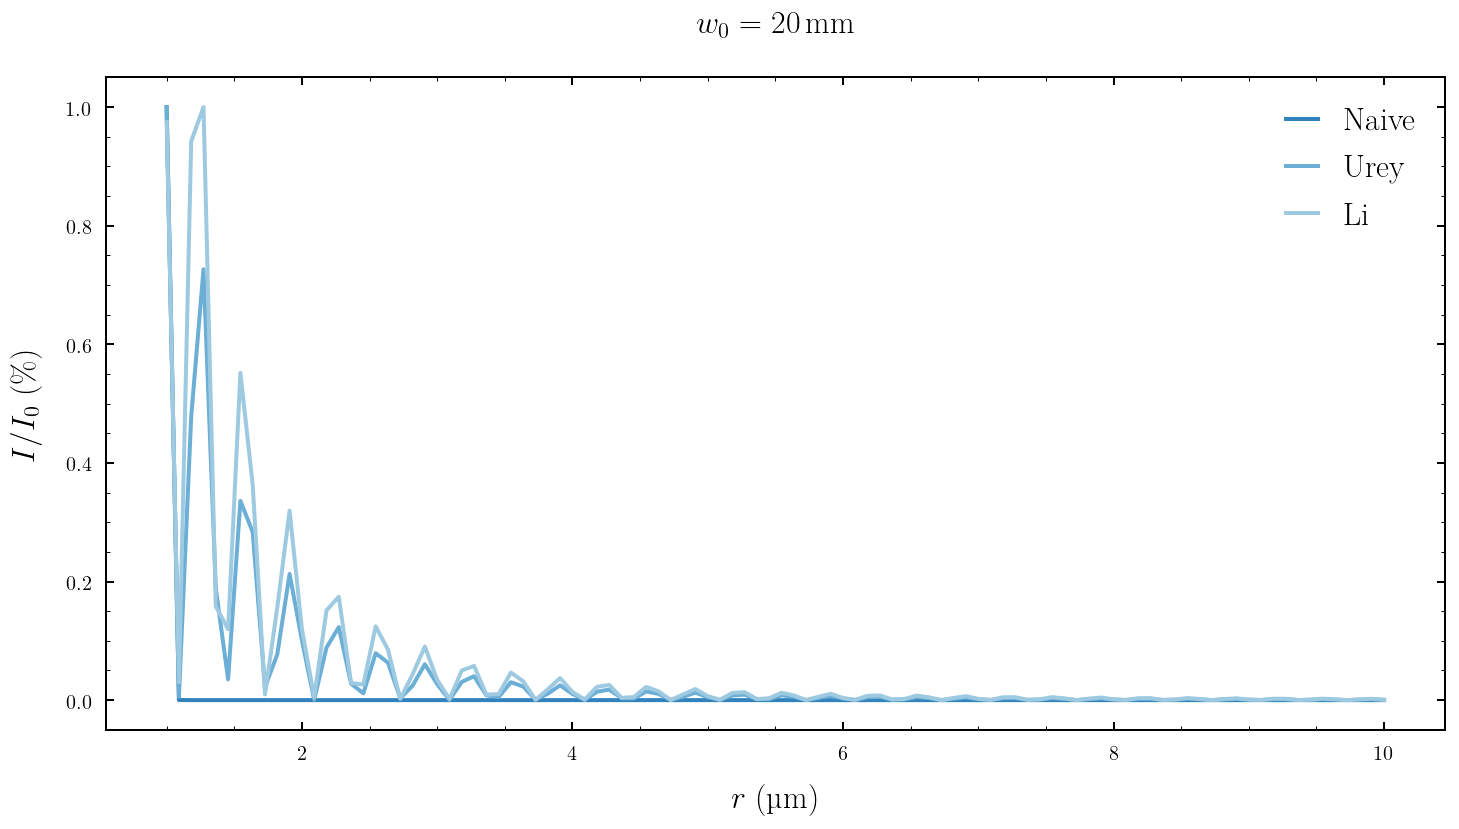

In [12]:
r = np.linspace(1e-6, 10e-6, 100)
w = 20e-3

plt.figure(figsize=(12, 6))
plt.title(r'$w_0=\SI{20}{\milli\meter}$')
plt.plot(r / 1e-6, intensity_naive(w, r), label='Naive', color=colors[0])
plt.plot(r / 1e-6, intensity_urey(w, r), label='Urey', color=colors[1])
plt.plot(r / 1e-6, intensity_li(w, r), label='Li', color=colors[2])
plt.xlabel(r'$r$ (\si{\micro\meter})')
plt.ylabel(r'$I/I_0$ (\si{\percent})')
plt.legend()
plt.show()